In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

get some basic info of data files

In [103]:
# ValueError: could not convert string to float: '8789-0'
def read_data_partial(given_fname, output_fname, lim=399999):
    content = []
    count = 1

    with open(given_fname, 'r') as fr:
        for line in fr:
            if count <= lim:
                #print(type(line), line)
                content.append(line)
                count += 1
    with open(output_fname, 'w') as fw:
        for line in content:
            # print(type(line), line)
            fw.write(line)
    
    data = pd.read_csv(output_fname, index_col=False)

    return data

## drop u, g, r bands

In [104]:
qso_train_partial = read_data_partial('quasar_train_catalog.csv', 'qso_train_partial.csv')
qso_train_drop = qso_train_partial[['z', 'r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_train_drop = qso_train_drop.replace(99.99, np.nan).dropna()
qso_train_drop = qso_train_drop[qso_train_drop['z'] < 7.5]
qso_train_drop = qso_train_drop[(qso_train_drop['r_LSST_magerr']>0.2)&(qso_train_drop['i_LSST_magerr']>0.2)]
redshifts26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 22.0]
redshifts26 = redshifts26[redshifts26['z_LSST_mag'] < 26.0]
redshifts26 = redshifts26['z']
qso_train_drop = qso_train_drop.drop(columns=['z', 'r_LSST_magerr', 'i_LSST_magerr'])
print('qso_train_catalog_z.csv partial data description: ')
qso_train_drop.describe()

qso_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000
mean,28.576193,26.616020,24.340320,24.201112,24.264969,24.132527
std,1.218340,1.654428,2.009015,2.089360,2.112093,2.108081
min,26.672280,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.689657,25.314514,23.136710,22.977195,23.069490,22.937156
50%,28.366448,26.540555,24.371926,24.306130,24.363508,24.192066
75%,29.189413,27.668971,25.789820,25.697926,25.766767,25.595761
max,38.902328,36.769079,32.115011,32.168396,32.742341,33.953075


(array([1986., 1725., 1511., 1102.,   95.,   74.,  366.,  489.,  380.,
         271.]),
 array([6.0001027 , 6.15004544, 6.29998818, 6.44993092, 6.59987366,
        6.7498164 , 6.89975914, 7.04970188, 7.19964462, 7.34958736,
        7.4995301 ]),
 <BarContainer object of 10 artists>)

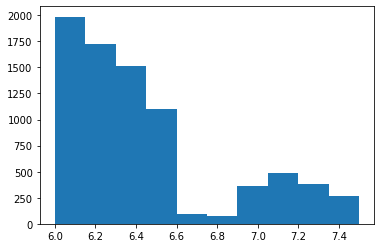

In [105]:
plt.hist(redshifts26)

In [106]:
# brown dwarf contaminants
mlt_train_partial = read_data_partial('mlt_train_catalog.csv', 'mlt_train_partial.csv', 599999)
mlt_train_drop = mlt_train_partial[['r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_train_drop = mlt_train_drop.replace(99.99, np.nan).dropna()
mlt_train_drop = mlt_train_drop[(mlt_train_drop['r_LSST_magerr']>0.2)&(mlt_train_drop['i_LSST_magerr']>0.2)]
mlt_train_drop = mlt_train_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('mlt_train_catalog_z.csv partial data description: ')
mlt_train_drop.describe()

mlt_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000
mean,27.846368,26.406966,24.814492,24.240174,23.941983,23.954949
std,0.866569,0.814599,0.652285,0.636041,0.633281,0.639802
min,26.565172,24.640153,22.966413,22.249321,21.884903,21.705643
25%,27.248302,25.848580,24.336131,23.782914,23.500752,23.511550
50%,27.631546,26.262440,24.722560,24.157117,23.877029,23.890512
75%,28.185010,26.792519,25.207176,24.619579,24.324040,24.337251
max,38.215437,36.198974,28.369839,27.735964,27.180561,27.305963


In [107]:
galaxies_patch8789_partial = read_data_partial('galaxies_train_catalog_patch8789.csv', 'galaxies_patch8789_partial.csv')
galaxies_patch8789_drop = galaxies_patch8789_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan).dropna()
galaxies_patch8789_drop = galaxies_patch8789_drop[(galaxies_patch8789_drop['r_LSST_magerr']>0.2)&(galaxies_patch8789_drop['i_LSST_magerr']>0.2)]
galaxies_patch8789_drop = galaxies_patch8789_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8789.csv partial data description: ')
galaxies_patch8789_drop.describe()

galaxies_train_catalog_patch8789.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000
mean,28.112741,27.507701,27.330679,27.226355,27.160891,27.154280
std,0.888656,0.950758,0.788433,0.796900,0.827853,0.977009
min,26.647539,25.462982,25.152190,24.748167,24.475726,24.258516
25%,27.518918,26.883531,26.837638,26.737179,26.657671,26.557470
50%,27.920273,27.314756,27.248012,27.172407,27.118375,27.041903
75%,28.465759,27.895376,27.710084,27.634895,27.594613,27.601858
max,40.029429,39.261958,39.647494,40.707497,38.204669,38.379259


In [108]:
galaxies_patch8786_partial = read_data_partial('galaxies_train_catalog_patch8786.csv', 'galaxies_patch8786_partial.csv')
galaxies_patch8786_drop = galaxies_patch8786_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan).dropna()
galaxies_patch8786_drop = galaxies_patch8786_drop[(galaxies_patch8786_drop['r_LSST_magerr']>0.2)&(galaxies_patch8786_drop['i_LSST_magerr']>0.2)]
galaxies_patch8786_drop = galaxies_patch8786_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8786.csv partial data description: ')
galaxies_patch8786_drop.describe()

galaxies_train_catalog_patch8786.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000
mean,28.100839,27.494196,27.312890,27.205311,27.141593,27.131091
std,0.886168,0.952284,0.787836,0.803832,0.842035,0.981601
min,26.573603,25.553776,25.107279,24.705397,24.460871,24.280885
25%,27.507428,26.871497,26.818026,26.714657,26.633417,26.535331
50%,27.905549,27.298753,27.235470,27.156032,27.102195,27.024873
75%,28.452895,27.883019,27.697073,27.620384,27.584425,27.588162
max,40.812877,40.422024,37.436853,38.037623,37.411129,37.630643


### drop missing values

In [109]:
print(qso_train_drop.head(), len(qso_train_drop))
print(np.where(np.isnan(qso_train_drop)))
print(len(mlt_train_drop))
print(np.where(np.isnan(mlt_train_drop)))
print(len(galaxies_patch8789_drop))
print(np.where(np.isnan(galaxies_patch8789_drop)))
print(len(galaxies_patch8786_drop))
print(np.where(np.isnan(galaxies_patch8786_drop)))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758 20759
(array([], dtype=int64), array([], dtype=int64))
40214
(array([], dtype=int64), array([], dtype=int64))
166180
(array([], dtype=int64), array([], dtype=int64))
156946
(array([], dtype=int64), array([], dtype=int64))


In [110]:
qso_train_drop['label'] = np.ones(len(qso_train_drop))
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))

### check the cleaned datasets and concatenate into new ones

In [111]:
print('qso:\n', qso_train_drop.head())
print('bd:\n', mlt_train_drop.head())
print('galaxies patch8789:\n', galaxies_patch8789_drop.head())
print('galaxies path8786:\n', galaxies_patch8786_drop.head())

qso:
       i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461   
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975   
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953   
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836   
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   

      label  
1281    1.0  
1307    1.0  
1329    1.0  
1344    1.0  
1350    1.0  
bd:
         i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
398247   26.888214   24.767034  24.160454  23.807130  23.455427  23.446447   
398253   26.758145   25.077703  24.012978  23.724390  23.529321  23.489750   
398350   26.817520   25.070334  24.192246  23.774151  23.644759  23.551041   
398458   26.976849   25.348521  24.372349  23.913859  23.949639  23.681874   
398464   26.788703   25.283402  24.121468  23.827350  23.8

In [112]:
# data concatenation to get training data
contaminants_drop = pd.concat([mlt_train_drop, galaxies_patch8789_drop, galaxies_patch8786_drop], ignore_index=True)
data_train_drop = pd.concat([qso_train_drop, contaminants_drop], ignore_index=True) # make sure that the data line up
X_drop = data_train_drop[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop = data_train_drop['label']

In [113]:
print(len(X_drop))

384099


In [114]:
X_drop.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000
mean,28.105037,27.338747,26.898356,26.741610,26.659483,26.646531
std,0.916743,1.058480,1.320838,1.417921,1.468364,1.548313
min,26.565172,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.487583,26.729171,26.520257,26.375729,26.271044,26.171445
50%,27.903062,27.208934,27.103179,27.019502,26.959260,26.869193
75%,28.471100,27.809780,27.602659,27.530272,27.490765,27.470353
max,40.812877,40.422024,39.647494,40.707497,38.204669,38.379259


## 24.0 < z < 26

In [115]:
qso_train_26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 24.0]
qso_train_26 = qso_train_26[qso_train_26['z_LSST_mag'] < 26.0]
print(len(qso_train_26))
mlt_train_26 = mlt_train_drop[mlt_train_drop['z_LSST_mag'] > 24.0]
mlt_train_26 = mlt_train_26[mlt_train_26['z_LSST_mag'] < 26.0]
print(len(mlt_train_26))
galaxies_patch8789_26 = galaxies_patch8789_drop[galaxies_patch8789_drop['z_LSST_mag'] > 24.0]
galaxies_patch8789_26 = galaxies_patch8789_26[galaxies_patch8789_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8789_26))
galaxies_patch8786_26 = galaxies_patch8786_drop[galaxies_patch8786_drop['z_LSST_mag'] > 24.0]
galaxies_patch8786_26 = galaxies_patch8786_26[galaxies_patch8786_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8786_26))

7514
13790
778
753


In [116]:
contaminants_26 = pd.concat([mlt_train_26, galaxies_patch8789_26, galaxies_patch8786_26], ignore_index=True)
data_train_26 = pd.concat([qso_train_26, contaminants_26], ignore_index=True)
X_drop_26 = data_train_26[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop_26 = data_train_26['label']

In [117]:
col_names = ['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X_drop_26[col] = X_drop_26[col_names[i]] - X_drop_26[col_names[j]]

X_drop_26_copy = X_drop_26.drop(columns=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'])

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


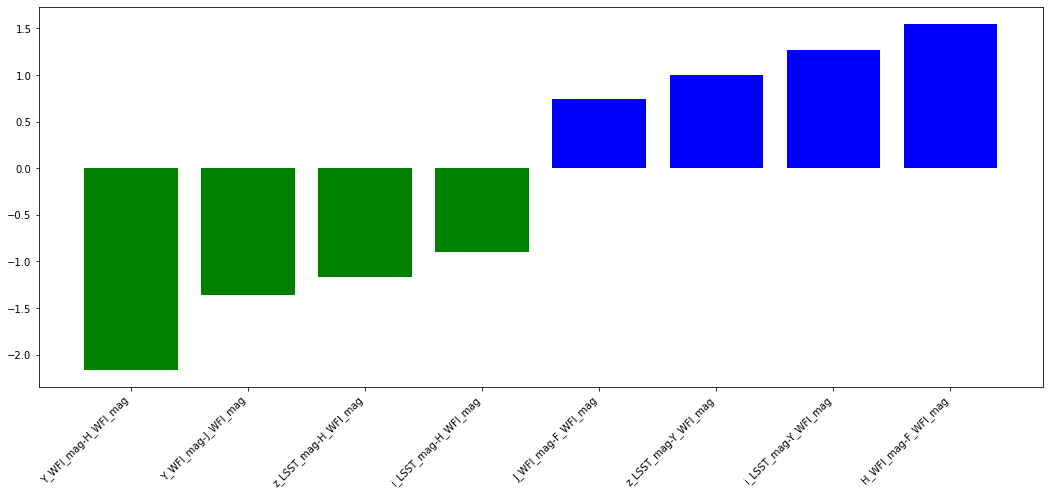

In [118]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X_drop_26_copy, Y_drop_26)
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X_drop_26_copy.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

In [119]:
# keep the columns with the highest influences & check if the dataframes look reasonable
X_drop_26 = X_drop_26[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-J_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'i_LSST_mag-H_WFI_mag', 'J_WFI_mag-F_WFI_mag', 'z_LSST_mag-Y_WFI_mag', 'i_LSST_mag-Y_WFI_mag', 'H_WFI_mag-F_WFI_mag']]

print(type(X_drop_26))
print('X with 24.0 < z < 26.0: \n', X_drop_26.head())

<class 'pandas.core.frame.DataFrame'>
X with 24.0 < z < 26.0: 
    i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   
1   27.524243   24.064202  18.581391  18.063651  17.962036  17.889791   
2   26.956233   24.175056  18.643111  18.057271  17.947544  17.923464   
3   27.085317   24.577786  18.568934  18.003694  17.874231  17.815912   
4   27.750373   24.204321  18.623443  18.056759  17.942237  17.873085   

   Y_WFI_mag-H_WFI_mag  Y_WFI_mag-J_WFI_mag  z_LSST_mag-H_WFI_mag  \
0             0.603390             0.515099              6.022002   
1             0.619356             0.517740              6.102166   
2             0.695568             0.585840              6.227512   
3             0.694703             0.565240              6.703555   
4             0.681206             0.566684              6.262084   

   i_LSST_mag-H_WFI_mag  J_WFI_mag-F_WFI_mag  z_LSST_mag-Y_WFI_mag  \
0           

In [120]:
X_drop_26_copy = X_drop_26.copy()

In [121]:
print(len(X_drop_26_copy))

22835


### color-color plots to decide which combinations should be used for decision boundaries 

check which ones are the most "separable"

In [39]:
import seaborn as sns

In [40]:
def color_plot(X, x_lab, y_lab):
    q = sns.jointplot(data=X, x=x_lab, y=y_lab, hue='label', kind='scatter', joint_kws={"alpha": 0.3})

### 22.0 < z < 26.0

In [43]:
X_drop_26_copy['label'] = Y_drop_26

/data0/sw/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


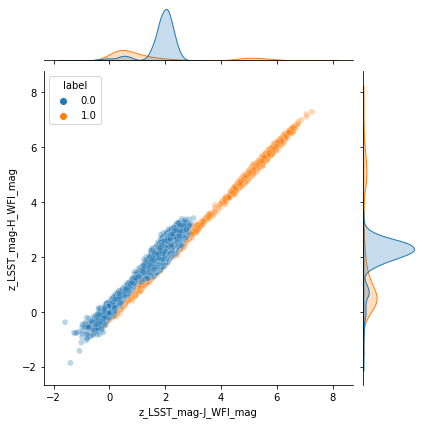

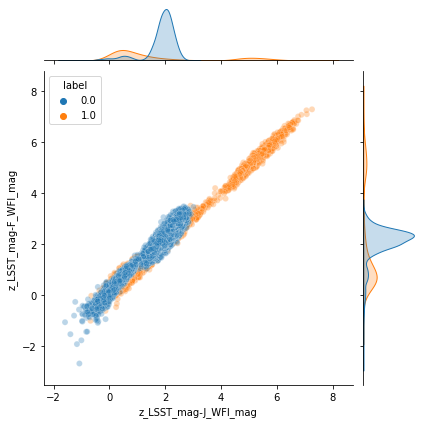

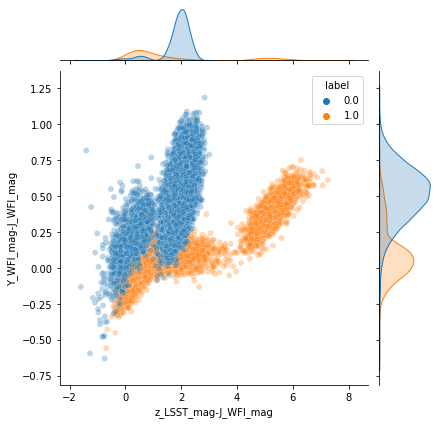

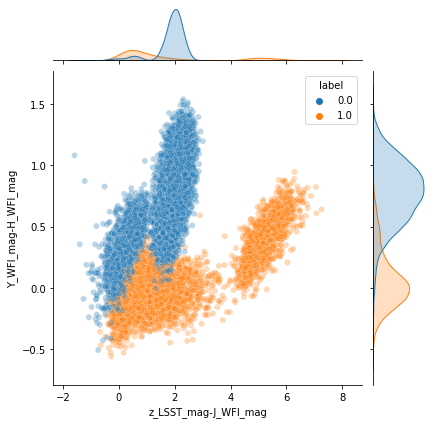

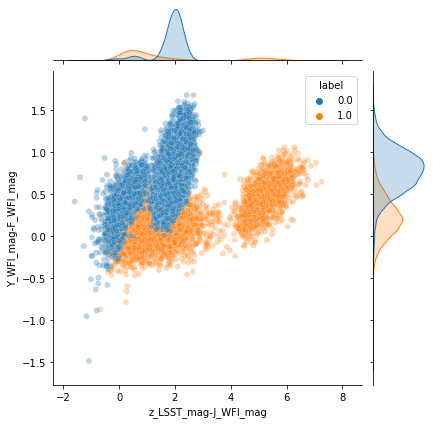

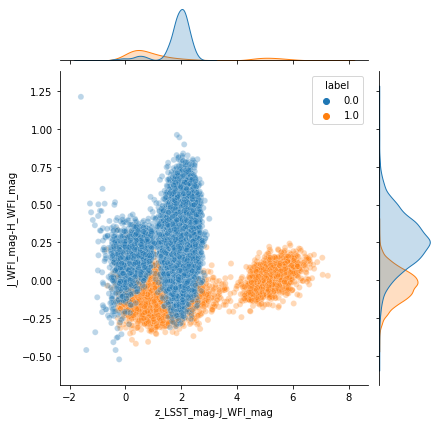

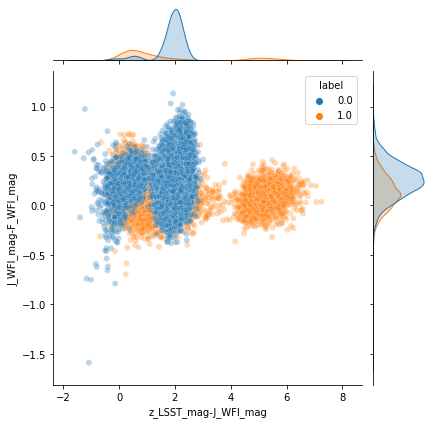

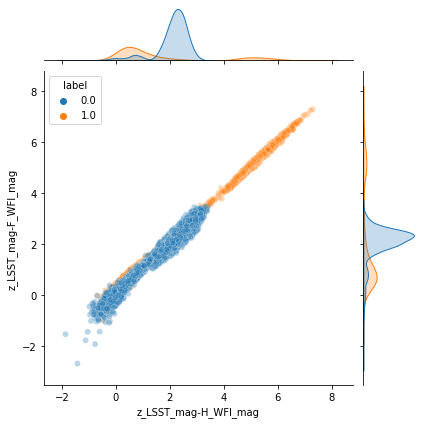

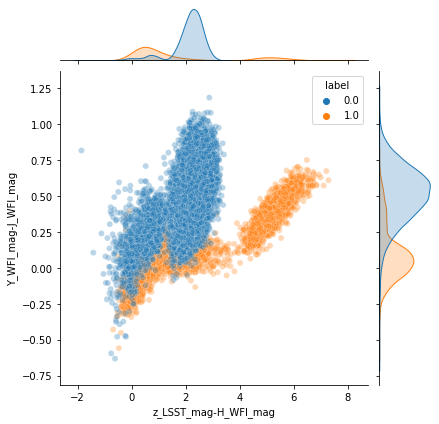

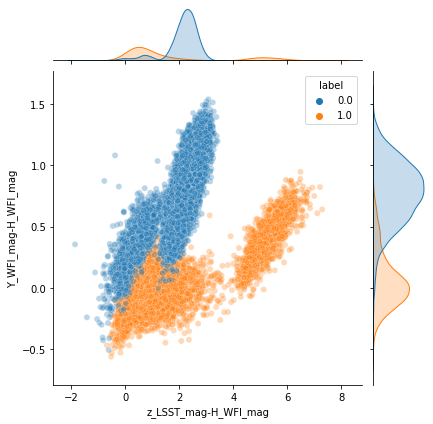

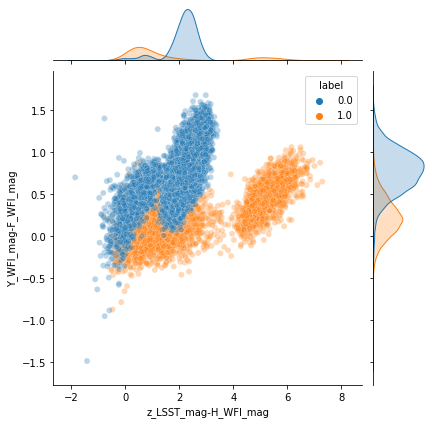

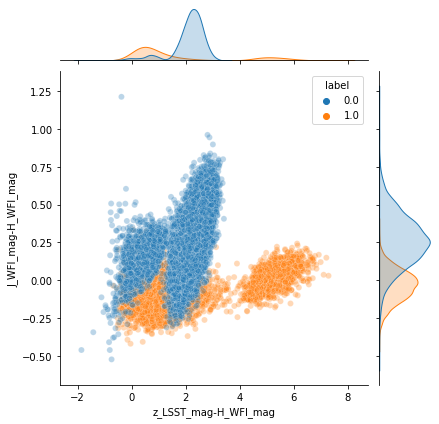

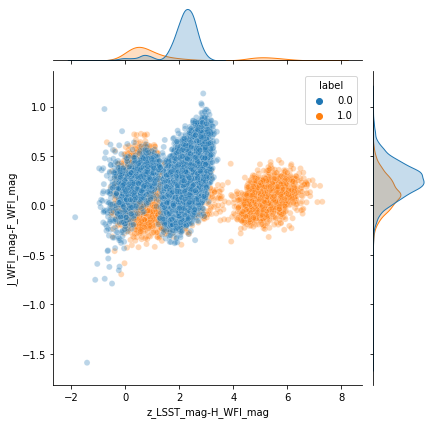

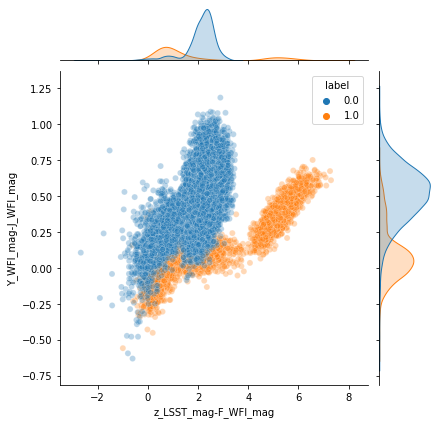

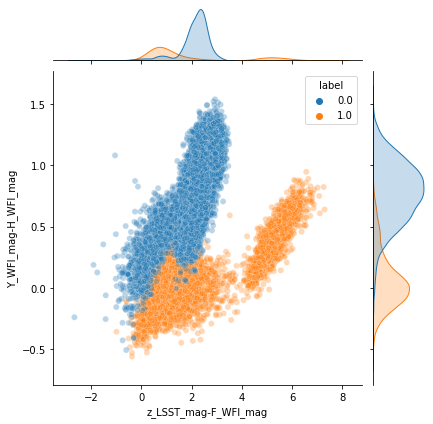

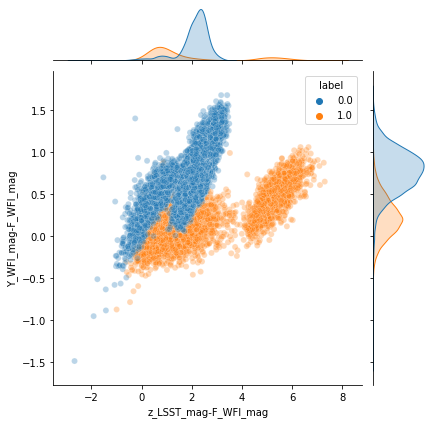

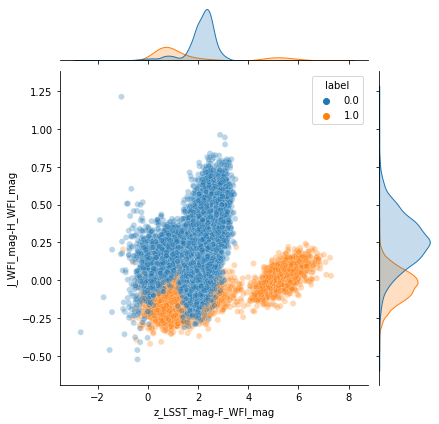

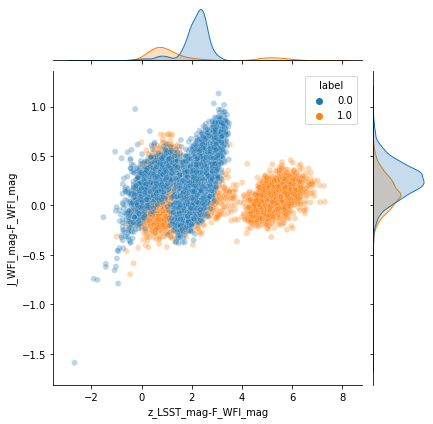

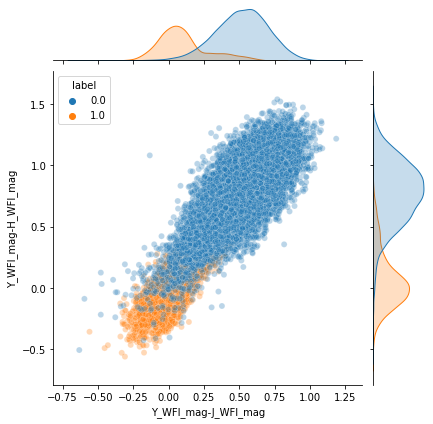

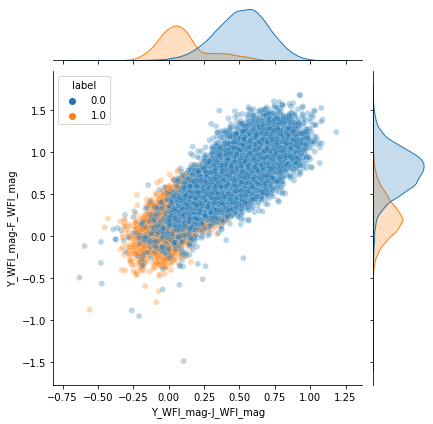

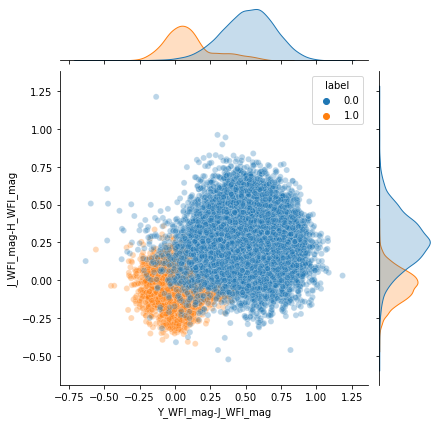

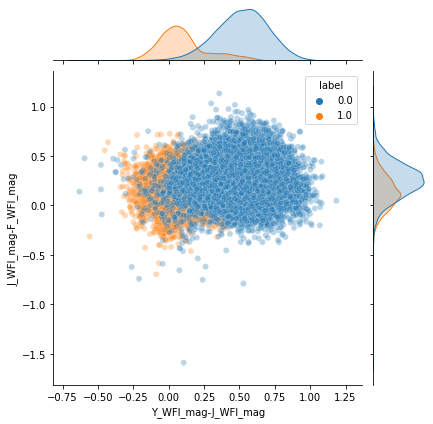

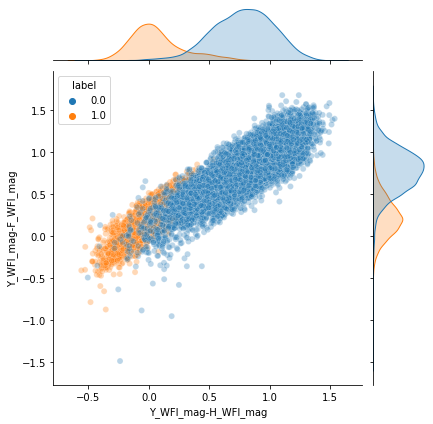

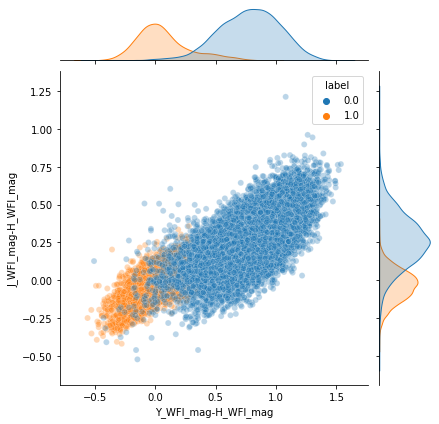

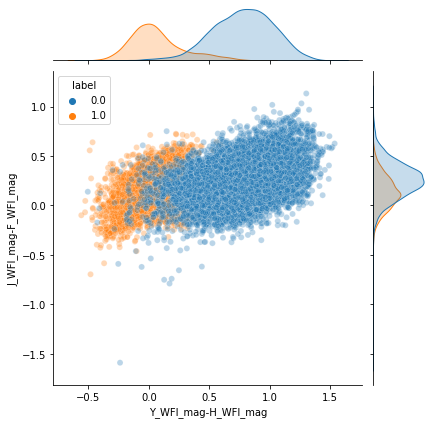

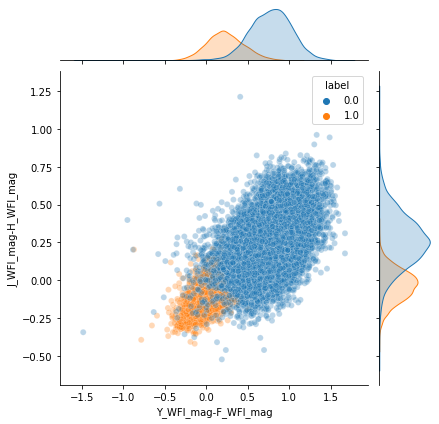

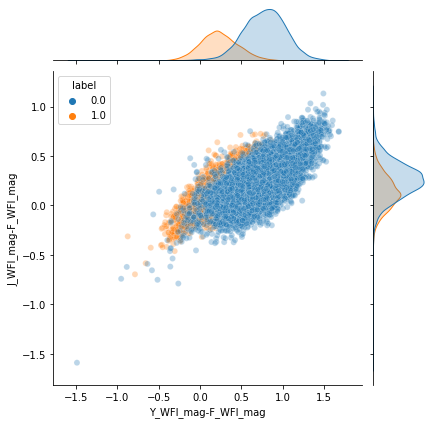

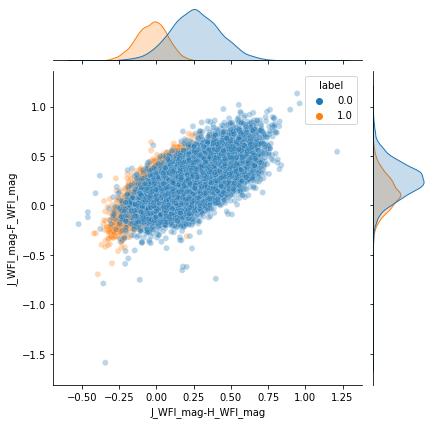

In [23]:
cols = X_drop_26_copy.columns
# print(len(cols))

for i in range(6, 14):
    x_lab = cols[i]
    # range may change later 
    for j in range(i+1, 14):
        y_lab = cols[j]
        color_plot(X_drop_26_copy, x_lab, y_lab)

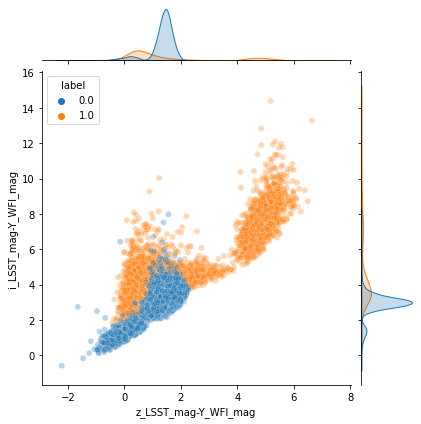

In [46]:
# x: z-Y
# y: i-Y
color_plot(X_drop_26_copy, 'z_LSST_mag-Y_WFI_mag', 'i_LSST_mag-Y_WFI_mag')

In [47]:
X_drop_26_copy = X_drop_26_copy.drop(columns=['label'])

## KNN Training

In [122]:
from numba import jit, cuda

In [123]:
@jit(forceobj=True, parallel=True) 
def knn_training(x1, x2, y1, y2, y, n, leaves):
    # format x1: X['r']
    # type: n -> list of integers
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    grid_params = {'n_neighbors' : n,
                   'leaf_size': leaves,
                   'weights' :  ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan'],
                  'p': [1, 2, 3, 4, 5, 6],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

    gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
    g_res = gs.fit(X_train, y_train)

    print('best score: ', g_res.best_score_)
    print('best params: ', g_res.best_params_)

In [124]:
def get_color_filter(clf, n_neighbors, weights, x1, x2, y1, y2, y):
    # Create color maps
    cmap_light = ListedColormap(['#75aff9', '#f7a844']) # blue, orange
    cmap_bold = ListedColormap(['#8dbcf9', '#f5a844']) 
    
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()

    # we create an instance of Neighbours Classifier and fit the data.
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = min(x1 - x2) - 1, max(x1 - x2) + 1
    y_min, y_max = min(y1 - y2) - 1, max(y1 - y2) + 1
    h = (x_max-x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.title("k = %i, weights = '%s'"
              % (n_neighbors, weights))

### 24 < z < 26

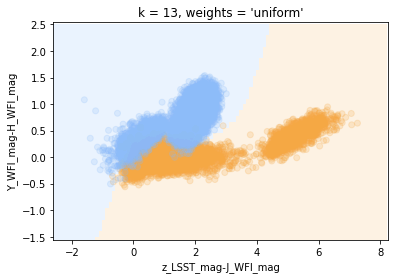

In [125]:
# x: z - J
# y: Y - H
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['J_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [7, 13, 19, 26, 30, 36], [3, 5, 6])
# best score:  0.9881756756756758
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 3, 'weights': 'uniform'}

filter1a = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=13, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1a, 13, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['J_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-J_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

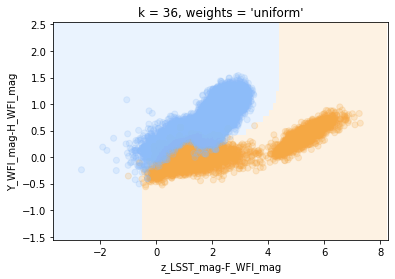

In [126]:
# x: z - F
# y: Y - H
# best score:  0.9898648648648649
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 36, 'p': 1, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['F_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [26, 30, 36, 40, 45, 50, 60], [3, 5])

filter1b = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=36, leaf_size=3, weights='uniform', p=1)
get_color_filter(filter1b, 36, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['F_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-F_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

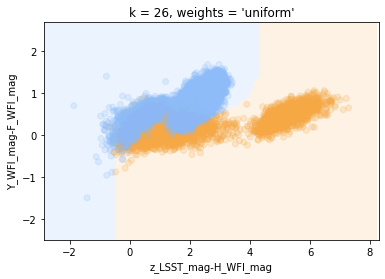

In [127]:
# x: z - H
# y: Y - F
# best score:  0.9463213213213213
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 26, 'p': 1, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['F_WFI_mag'], Y_drop_26, [13, 19, 26, 30, 36, 40, 45, 50, 60], [3, 5, 6])

filter1c = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=26, leaf_size=3, weights='uniform', p=1)
get_color_filter(filter1c, 26, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['F_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-H_WFI_mag')
plt.ylabel('Y_WFI_mag-F_WFI_mag')
plt.show()

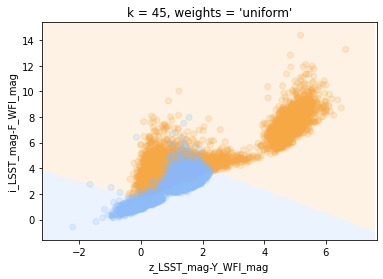

In [128]:
# x: z - Y
# y: i - Y
# best score:  0.9678428428428428
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 45, 'p': 5, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26, [13, 19, 26, 30, 36, 40, 45, 50], [3, 5])

filter1d = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=45, leaf_size=3, weights='uniform', p=5)
get_color_filter(filter1d, 45, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-F_WFI_mag')
plt.show()

## Test (knn+snr)

In [129]:
# retrieve redshift for later usage
qso_test = pd.read_csv('quasar_test_catalog.csv', index_col=False)
qso_test = qso_test[['z', 'r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test = qso_test.replace(99.99, np.nan).dropna()
qso_test = qso_test[(qso_test['r_LSST_magerr']>0.2)&(qso_test['i_LSST_magerr']>0.2)]
qso_test = qso_test.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
# qso_test = qso_test[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000
mean,6.334597,28.835404,26.798711,25.931247,25.903342,25.938094,25.724927
std,0.310122,1.238984,1.679970,1.773994,1.803031,1.796843,1.760516
min,6.000191,26.618546,23.163809,20.452226,20.223916,20.227606,20.164541
25%,6.104868,27.976921,25.507942,24.531768,24.504636,24.559612,24.386106
50%,6.244405,28.662272,26.856947,25.846617,25.823882,25.846930,25.666564
75%,6.469143,29.429633,27.855877,27.204031,27.190811,27.212475,26.946348
max,8.482816,35.495708,36.798806,35.672331,33.879891,34.514265,34.228085


In [130]:
galaxies_patch8788 = read_data_partial('galaxies_train_catalog_patch8788.csv', 'galaxies_patch8788_245.csv', 30000)
galaxies_patch8788 = galaxies_patch8788.replace(99.99, np.nan).dropna()
galaxies_patch8788 = galaxies_patch8788[['z', 'r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8788_26 = galaxies_patch8788[(galaxies_patch8788['r_LSST_magerr']>0.2)&(galaxies_patch8788['i_LSST_magerr']>0.2)]
galaxies_patch8788_26 = galaxies_patch8788.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8788.csv data description: ')
galaxies_patch8788.describe()

galaxies_train_catalog_patch8788.csv data description: 


,z,r_LSST_magerr,i_LSST_magerr,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000
mean,1.032609,0.071881,0.074232,25.064565,24.472561,24.263562,24.133942,24.032490,23.970953
std,0.014266,0.336052,0.207255,1.258280,1.250795,1.294158,1.348217,1.403003,1.451221
min,1.005989,0.010337,0.010588,20.738443,20.199310,19.730171,19.315425,18.971169,18.750817
25%,1.020363,0.025039,0.027430,24.321473,23.749411,23.524088,23.357096,23.211484,23.120767
50%,1.033982,0.045740,0.049470,25.208614,24.607205,24.439207,24.332423,24.249539,24.205313
75%,1.045150,0.079893,0.086826,25.930392,25.342387,25.182842,25.094375,25.045359,25.005333
max,1.055212,43.286299,23.300493,32.004925,31.083271,28.285061,28.161714,30.885336,32.729688


In [131]:
mlt_test = read_data_partial('mlt_test_catalog_z.csv', 'mlt_test_catalog_z26.csv', 120000)
mlt_test = mlt_test[['spt', 'r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_test = mlt_test.replace(99.99, np.nan).dropna()
mlt_test = mlt_test[(mlt_test['r_LSST_magerr']>0.2)&(mlt_test['i_LSST_magerr']>0.2)]
mlt_test = mlt_test.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
mlt_test['z'] = np.zeros(mlt_test.shape[0])
print('mlt_test_catalog partial data description: ')
mlt_test.describe()

mlt_test_catalog partial data description: 


,spt,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,z
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.0
mean,13.067001,27.294287,25.684152,24.222748,23.659324,23.357716,23.372401,0.0
std,2.983720,0.388016,0.231342,0.295505,0.317678,0.377004,0.388734,0.0
min,7.000000,26.601001,24.571247,22.301314,22.013013,21.873094,21.742619,0.0
25%,11.000000,27.036202,25.538164,24.027244,23.452812,23.114613,23.130337,0.0
50%,13.000000,27.206518,25.726646,24.225623,23.658451,23.360445,23.377344,0.0
75%,15.000000,27.458651,25.871890,24.418692,23.872214,23.612628,23.627727,0.0
max,29.000000,32.622297,25.999972,25.767020,25.011076,24.808649,25.154299,0.0


In [132]:
qso_test_copy = qso_test.copy()
qso_test_copy['label'] = np.ones(len(qso_test_copy))
qso_test_copy['spt'] = np.zeros(len(qso_test_copy))
galaxies_patch8788_copy = galaxies_patch8788.copy()
galaxies_patch8788_copy['label'] = np.zeros(len(galaxies_patch8788_copy))
galaxies_patch8788_copy['spt'] = np.zeros(len(galaxies_patch8788_copy))

In [133]:
mlt_test_copy = mlt_test.copy()
mlt_test_copy['label'] = np.zeros(len(mlt_test_copy))
mlt_test_26 = mlt_test[(mlt_test['z_LSST_mag']>24.0)&(mlt_test['z_LSST_mag']<26.0)]
test0 = pd.concat([qso_test_copy, galaxies_patch8788_copy, mlt_test_copy], ignore_index=True)
test = test0[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'label']]
test.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000
mean,26.330656,25.189267,24.420450,24.131116,23.965228,23.917886,0.103681
std,1.684789,1.313506,1.211908,1.305913,1.390285,1.377839,0.304850
min,20.738443,20.199310,19.730171,19.315425,18.971169,18.750817,0.000000
25%,25.199695,24.538908,23.929998,23.468960,23.182110,23.174899,0.000000
50%,26.869211,25.478009,24.318858,23.886534,23.682393,23.670638,0.000000
75%,27.317233,25.843108,24.892854,24.774591,24.718586,24.663740,0.000000
max,35.495708,36.798806,35.672331,33.879891,34.514265,34.228085,1.000000


In [134]:
qso_test_26 = qso_test[qso_test['z_LSST_mag'] < 26.0]
qso_test_26 = qso_test_26[qso_test_26['z_LSST_mag'] > 24.0]
qso_test_26_copy = qso_test_26.copy()
print('length of qso test catalog with 24 < z < 26:', len(qso_test_26))

length of qso test catalog with 24 < z < 26: 1344


In [151]:
test_copy = test.copy()
test_copy = test_copy[test_copy['z_LSST_mag'] > 24.0]
test_copy = test_copy[test_copy['z_LSST_mag'] < 26.0]
print(len(test_copy))
print(len(test_copy[test_copy['label'] == 1]))

29983
1344


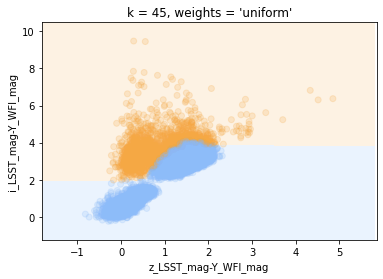

1775


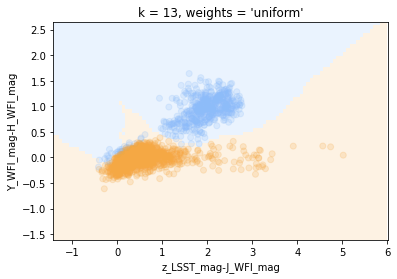

1262


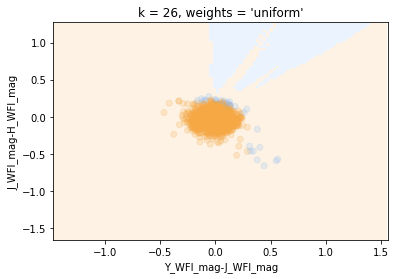

1231


"\n# x: z - F\n# y: Y - H\nfeatures1b = [X_drop_26['z_LSST_mag']-X_drop_26['F_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag']]\nX1b = np.array(features1b).transpose()\nfilter1b.fit(X1b, Y_drop_26)\nlabels = filter1b.predict(np.array([test_copy['z_LSST_mag']-test_copy['F_WFI_mag'], test_copy['Y_WFI_mag']-test_copy['H_WFI_mag']]).transpose())\n\nget_color_filter(filter1b, 36, 'uniform', test_copy['z_LSST_mag'], test_copy['F_WFI_mag'], test_copy['Y_WFI_mag'], test_copy['H_WFI_mag'], labels)\nplt.xlabel('z_LSST_mag-F_WFI_mag')\nplt.ylabel('Y_WFI_mag-H_WFI_mag')\nplt.show()\n\ntest_copy['label'] = labels\ntest_copy = test_copy[test_copy['label'] == 1]\nprint(len(test_copy))\n\n# x: z - H\n# y: Y - F\nfeatures1c = [X_drop_26['z_LSST_mag']-X_drop_26['H_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['F_WFI_mag']]\nX1c = np.array(features1c).transpose()\nfilter1c.fit(X1c, Y_drop_26)\nlabels = filter1c.predict(np.array([test_copy['z_LSST_mag']-test_copy['H_WFI_mag'], test_copy['Y_WFI_mag']

In [152]:
# x: z - Y
# y: i - Y
features1d = [X_drop_26['z_LSST_mag']-X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag']]
X1d = np.array(features1d).transpose()
filter1d.fit(X1d, Y_drop_26)
labels = filter1d.predict(np.array([test_copy['z_LSST_mag']-test_copy['Y_WFI_mag'], test_copy['i_LSST_mag']-test_copy['Y_WFI_mag']]).transpose())

get_color_filter(filter1c, 45, 'uniform', test_copy['z_LSST_mag'], test_copy['Y_WFI_mag'], test_copy['i_LSST_mag'], test_copy['Y_WFI_mag'], labels)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))


# x: z - J
# y: Y - H
features1a = [X_drop_26['z_LSST_mag']-X_drop_26['J_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag']]
X1a = np.array(features1a).transpose()
filter1a.fit(X1a, Y_drop_26)
labels = filter1a.predict(np.array([test_copy['z_LSST_mag']-test_copy['J_WFI_mag'], test_copy['Y_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

get_color_filter(filter1a, 13, 'uniform', test_copy['z_LSST_mag'], test_copy['J_WFI_mag'], test_copy['Y_WFI_mag'], test_copy['H_WFI_mag'], labels)
plt.xlabel('z_LSST_mag-J_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))

# Y - J
# J - H
# {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 26, 'p': 3, 'weights': 'uniform'}
filter1e = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=26, leaf_size=3, weights='uniform', p=3)
features1e = [X_drop_26['Y_WFI_mag']-X_drop_26['J_WFI_mag'], X_drop_26['J_WFI_mag']-X_drop_26['H_WFI_mag']]
X1e = np.array(features1e).transpose()
filter1e.fit(X1e, Y_drop_26)
labels = filter1e.predict(np.array([test_copy['Y_WFI_mag']-test_copy['J_WFI_mag'], test_copy['J_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

get_color_filter(filter1e, 26, 'uniform', test_copy['Y_WFI_mag'], test_copy['J_WFI_mag'], test_copy['J_WFI_mag'], test_copy['H_WFI_mag'], labels)
plt.xlabel('Y_WFI_mag-J_WFI_mag')
plt.ylabel('J_WFI_mag-H_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))
'''
# x: z - F
# y: Y - H
features1b = [X_drop_26['z_LSST_mag']-X_drop_26['F_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag']]
X1b = np.array(features1b).transpose()
filter1b.fit(X1b, Y_drop_26)
labels = filter1b.predict(np.array([test_copy['z_LSST_mag']-test_copy['F_WFI_mag'], test_copy['Y_WFI_mag']-test_copy['H_WFI_mag']]).transpose())

get_color_filter(filter1b, 36, 'uniform', test_copy['z_LSST_mag'], test_copy['F_WFI_mag'], test_copy['Y_WFI_mag'], test_copy['H_WFI_mag'], labels)
plt.xlabel('z_LSST_mag-F_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))

# x: z - H
# y: Y - F
features1c = [X_drop_26['z_LSST_mag']-X_drop_26['H_WFI_mag'], X_drop_26['Y_WFI_mag']-X_drop_26['F_WFI_mag']]
X1c = np.array(features1c).transpose()
filter1c.fit(X1c, Y_drop_26)
labels = filter1c.predict(np.array([test_copy['z_LSST_mag']-test_copy['H_WFI_mag'], test_copy['Y_WFI_mag']-test_copy['F_WFI_mag']]).transpose())

get_color_filter(filter1c, 26, 'uniform', test_copy['z_LSST_mag'], test_copy['H_WFI_mag'], test_copy['Y_WFI_mag'], test_copy['F_WFI_mag'], labels)
plt.xlabel('z_LSST_mag-H_WFI_mag')
plt.ylabel('Y_WFI_mag-F_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))
'''


In [153]:
print(test_copy.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
1      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
2      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
3      27.145200   24.595492  23.955002  23.879654  23.708573  23.422524   
4      27.109296   24.386038  24.050289  24.216277  24.179047  23.936038   
...          ...         ...        ...        ...        ...        ...   
1219   28.174040   24.392064  23.948284  23.908674  23.905087  23.667442   
1220   27.908976   25.064898  24.622730  24.709894  24.763848  24.751605   
1221   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1222   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1223   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   

      label         z  
0       1.0  6.406638  
1       1.0  6.199295  
2       1.0  6.

In [154]:
print(max(test_copy.merge(qso_test_26)['z_LSST_mag']))

25.999146522798828


In [155]:
test_copy.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.0
mean,28.102953,25.031206,24.472563,24.480250,24.509168,24.311155,1.0
std,0.938834,0.555895,0.699728,0.741132,0.733770,0.725187,0.0
min,26.721256,24.000488,20.452226,20.223916,20.227606,20.164541,1.0
25%,27.447144,24.554659,24.009503,23.995638,24.021825,23.830324,1.0
50%,27.917251,25.031685,24.484092,24.495671,24.532448,24.326506,1.0
75%,28.508282,25.522004,24.991142,25.016234,25.024256,24.824515,1.0
max,34.283547,25.999147,26.083287,26.290053,26.334833,26.129822,1.0


In [156]:
qso_test_26.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,6.203189,28.090738,25.065672,24.497162,24.499561,24.522090,24.315218
std,0.151856,0.931869,0.558119,0.704052,0.745237,0.734651,0.733402
min,6.000429,26.721256,24.000488,20.452226,20.223916,20.227606,20.164541
25%,6.079264,27.447909,24.597904,24.018782,24.000946,24.038322,23.834322
50%,6.169311,27.895590,25.078322,24.504136,24.500458,24.534175,24.326926
75%,6.306962,28.490091,25.555681,25.024132,25.037215,25.031410,24.830603
max,7.015233,34.283547,25.999147,26.175825,26.290053,26.334833,26.129822


In [157]:
tp = test_copy.merge(qso_test_26)
# qso_test_26 - tp = omitted positives = false negatives
fn = pd.merge(tp, qso_test_26, on=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [158]:
tp.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label,z
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.0,1224.000000
mean,28.102005,25.027651,24.480753,24.489431,24.517066,24.310604,1.0,6.197592
std,0.940273,0.555174,0.692196,0.731817,0.727607,0.726731,0.0,0.147414
min,26.721256,24.000488,20.452226,20.223916,20.227606,20.164541,1.0,6.000429
25%,27.445934,24.551976,24.012583,24.000946,24.036085,23.824011,1.0,6.079264
50%,27.915547,25.029093,24.490239,24.500458,24.535573,24.320161,1.0,6.165573
75%,28.506211,25.516613,24.992360,25.017040,25.028908,24.826221,1.0,6.286130
max,34.283547,25.999147,26.083287,26.290053,26.334833,26.129822,1.0,7.015233


In [159]:
fn = fn.rename(columns={'z_y': 'z'})
fn = fn[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'z']]
fn.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,z
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,27.975815,25.453487,24.664528,24.602889,24.573335,24.362278,6.260272
std,0.836272,0.425772,0.799364,0.867153,0.804491,0.800026,0.182508
min,26.725294,24.145817,22.312847,22.054529,21.997793,21.742369,6.001783
25%,27.470649,25.227118,24.133412,24.014056,24.071359,23.854200,6.080543
50%,27.773640,25.563978,24.620300,24.520635,24.515257,24.375657,6.272467
75%,28.335191,25.770612,25.256453,25.342597,25.191954,24.898679,6.432061
max,32.318376,25.993991,26.175825,26.229560,26.199572,25.892204,6.559240


In [160]:
# true negative intersect pred positive = false positive
fp = pd.merge(tp, test_copy, on=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [161]:
fp = fp.rename(columns={'label_y': 'pred label'})
false_positive = test0[test0.z_LSST_mag.isin(fp['z_LSST_mag'])]
false_positive.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label,spt,r_LSST_magerr,i_LSST_magerr
count,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,0.0,0.0
mean,0.0,28.268876,25.652831,23.040471,22.874925,23.128232,24.407459,0.0,26.000000,NaN,NaN
std,0.0,0.666801,0.265517,0.549456,0.643364,0.475789,0.381753,0.0,7.937254,NaN,NaN
min,0.0,27.295868,25.236566,22.301314,22.013013,22.478709,23.857991,0.0,8.000000,NaN,NaN
25%,0.0,27.804664,25.487924,22.805351,22.632776,22.881431,24.186616,0.0,29.000000,NaN,NaN
50%,0.0,28.374151,25.727296,22.848671,22.656947,23.005068,24.514083,0.0,29.000000,NaN,NaN
75%,0.0,28.719899,25.825888,23.239791,23.070780,23.384493,24.577815,0.0,29.000000,NaN,NaN
max,0.0,29.162988,25.978329,24.043028,24.047406,23.882001,24.951281,0.0,29.000000,NaN,NaN


In [96]:
print('w/ SNR constraints, 24 < z <26:\n')
print('precision:', round(1137/(1137+17), 4))
print('recall:', round(1137/(1137+207), 4))

w/ SNR constraints, 24 < z <26:

precision: 0.9853
recall: 0.846


### qso: redshift distributions, magnitudes (all)
### contaminants: brown dwarfs' spectral types and magnitudes; galaxies magnitudes

predicted qsos redshift distribution:


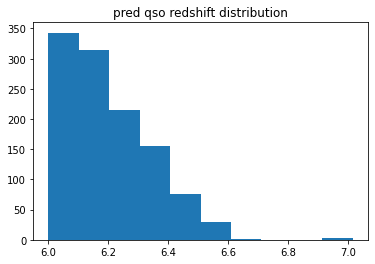

pred qsos z-band distribution:


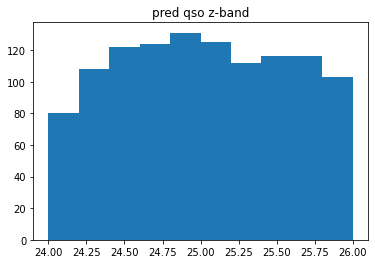

pred qsos Y-band distribution:


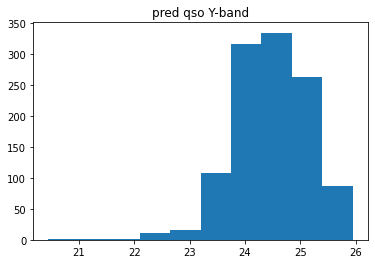

pred qsos J-band distribution:


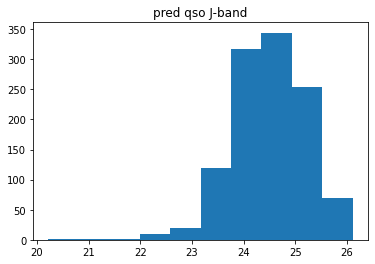

pred qsos H-band distribution:


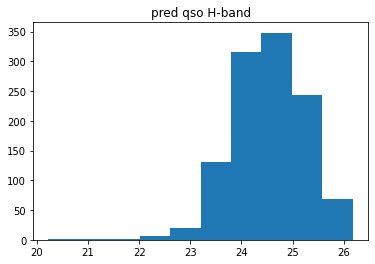

pred qsos F-band distribution:


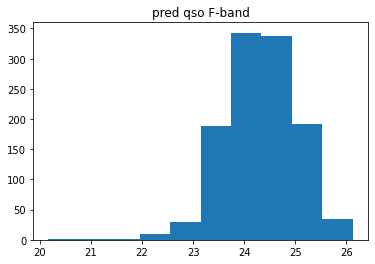

In [97]:
# qso distributions
print('predicted qsos redshift distribution:')
plt.hist(tp['z'])
plt.title('pred qso redshift distribution')
plt.show()
print('pred qsos z-band distribution:')
plt.hist(tp['z_LSST_mag'])
plt.title('pred qso z-band')
plt.show()
print('pred qsos Y-band distribution:')
plt.hist(tp['Y_WFI_mag'])
plt.title('pred qso Y-band')
plt.show()
print('pred qsos J-band distribution:')
plt.hist(tp['J_WFI_mag'])
plt.title('pred qso J-band')
plt.show()
print('pred qsos H-band distribution:')
plt.hist(tp['H_WFI_mag'])
plt.title('pred qso H-band')
plt.show()
print('pred qsos F-band distribution:')
plt.hist(tp['F_WFI_mag'])
plt.title('pred qso F-band')
plt.show()

missing qsos redshift distribution:


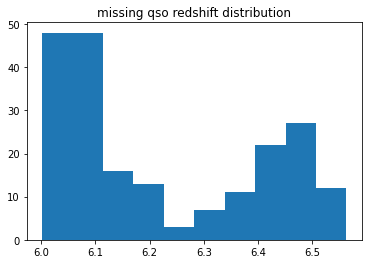

missing qsos z-band distribution:


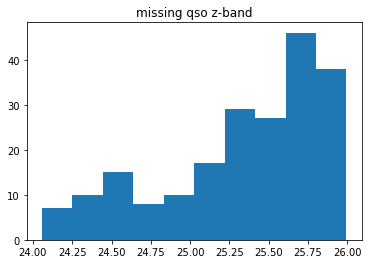

missing qsos Y-band distribution:


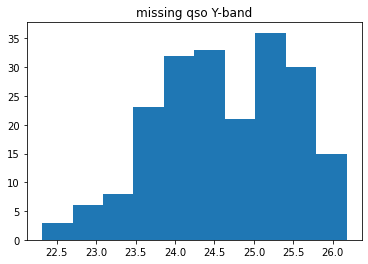

missing qsos J-band distribution:


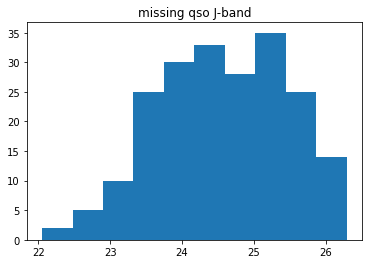

missing qsos H-band distribution:


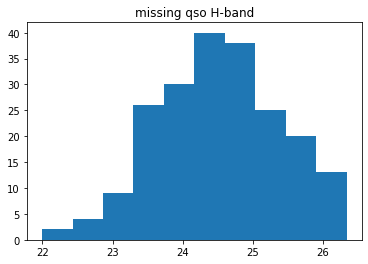

missing qsos F-band distribution:


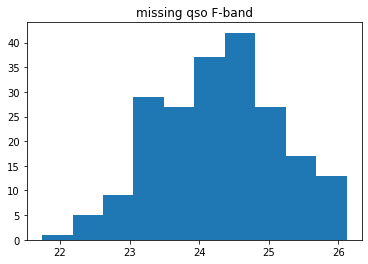

In [98]:
# missing qso distributions
print('missing qsos redshift distribution:')
plt.hist(fn['z'])
plt.title('missing qso redshift distribution')
plt.show()
print('missing qsos z-band distribution:')
plt.hist(fn['z_LSST_mag'])
plt.title('missing qso z-band')
plt.show()
print('missing qsos Y-band distribution:')
plt.hist(fn['Y_WFI_mag'])
plt.title('missing qso Y-band')
plt.show()
print('missing qsos J-band distribution:')
plt.hist(fn['J_WFI_mag'])
plt.title('missing qso J-band')
plt.show()
print('missing qsos H-band distribution:')
plt.hist(fn['H_WFI_mag'])
plt.title('missing qso H-band')
plt.show()
print('missing qsos F-band distribution:')
plt.hist(fn['F_WFI_mag'])
plt.title('missing qso F-band')
plt.show()

false positives spectral type distribution:


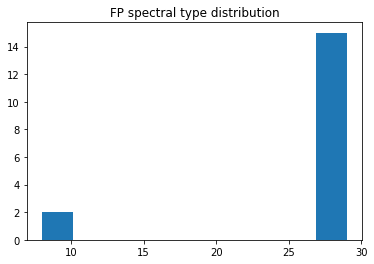

false positives z-band distribution:


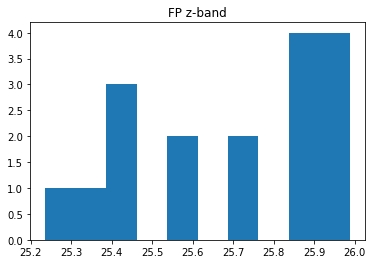

false positives Y-band distribution:


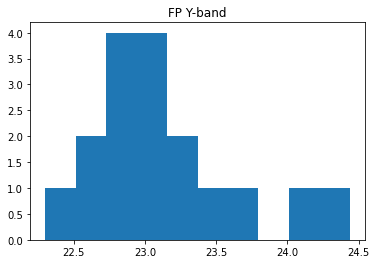

false positives J-band distribution:


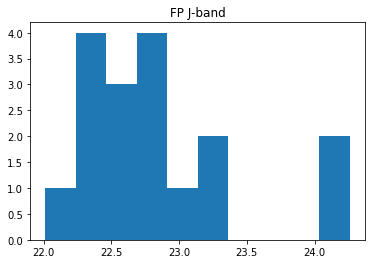

false positives H-band distribution:


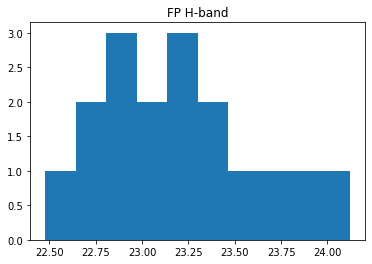

false positives F-band distribution:


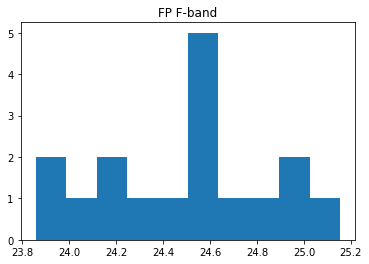

In [99]:
# false positives distribution
# FP distributions
print('false positives spectral type distribution:')
plt.hist(false_positive['spt'])
plt.title('FP spectral type distribution')
plt.show()
print('false positives z-band distribution:')
plt.hist(false_positive['z_LSST_mag'])
plt.title('FP z-band')
plt.show()
print('false positives Y-band distribution:')
plt.hist(false_positive['Y_WFI_mag'])
plt.title('FP Y-band')
plt.show()
print('false positives J-band distribution:')
plt.hist(false_positive['J_WFI_mag'])
plt.title('FP J-band')
plt.show()
print('false positives H-band distribution:')
plt.hist(false_positive['H_WFI_mag'])
plt.title('FP H-band')
plt.show()
print('false positives F-band distribution:')
plt.hist(false_positive['F_WFI_mag'])
plt.title('FP F-band')
plt.show()

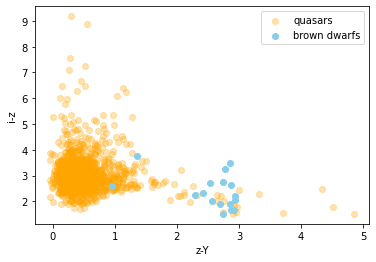

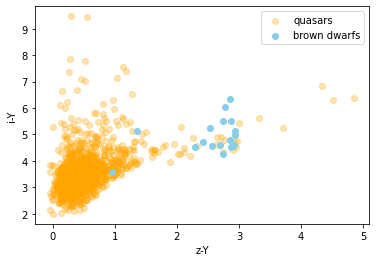

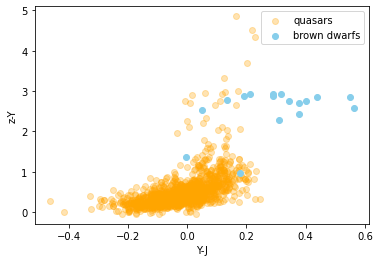

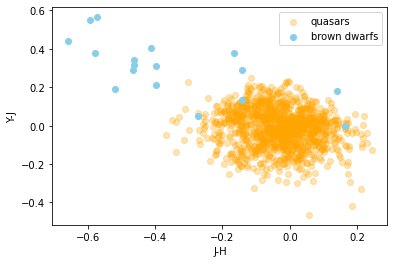

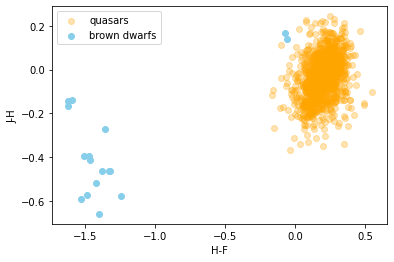

In [100]:
#  i-z vs z-Y
plt.scatter(tp['z_LSST_mag']-tp['Y_WFI_mag'], tp['i_LSST_mag']-tp['z_LSST_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], false_positive['i_LSST_mag']-false_positive['z_LSST_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('z-Y')
plt.ylabel('i-z')
plt.legend()
plt.show()

# i-Y bs z-Y
plt.scatter(tp['z_LSST_mag']-tp['Y_WFI_mag'], tp['i_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], false_positive['i_LSST_mag']-false_positive['Y_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('z-Y')
plt.ylabel('i-Y')
plt.legend()
plt.show()

#  z-Y vs Y-J
plt.scatter(tp['Y_WFI_mag']-tp['J_WFI_mag'], tp['z_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('Y-J')
plt.ylabel('z-Y')
plt.legend()
plt.show()

# Y-J vs J-H
plt.scatter(tp['J_WFI_mag']-tp['H_WFI_mag'], tp['Y_WFI_mag']-tp['J_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['J_WFI_mag']-false_positive['H_WFI_mag'], false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('J-H')
plt.ylabel('Y-J')
plt.legend()
plt.show()

# J-H vs H-F
plt.scatter(tp['H_WFI_mag']-tp['F_WFI_mag'], tp['J_WFI_mag']-tp['H_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['H_WFI_mag']-false_positive['F_WFI_mag'], false_positive['J_WFI_mag']-false_positive['H_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('H-F')
plt.ylabel('J-H')
plt.legend()
plt.show()

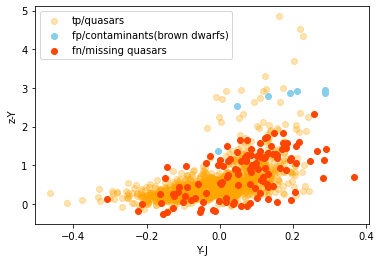

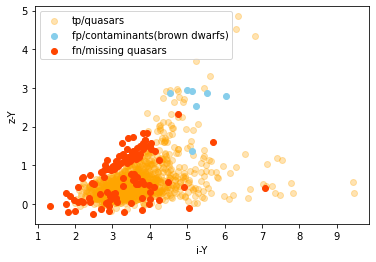

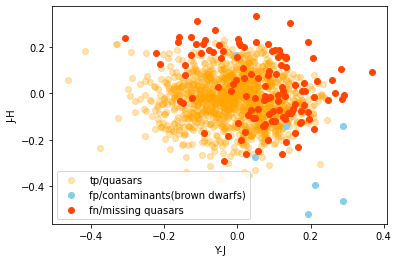

In [162]:
#  z-Y vs Y-J
plt.scatter(tp['Y_WFI_mag']-tp['J_WFI_mag'], tp['z_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='tp/quasars', color='orange')
plt.scatter(false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], label='fp/contaminants(brown dwarfs)', color='skyblue')
plt.scatter(fn['Y_WFI_mag']-fn['J_WFI_mag'], fn['z_LSST_mag']-fn['Y_WFI_mag'], label='fn/missing quasars', color='orangered')
plt.xlabel('Y-J')
plt.ylabel('z-Y')
plt.legend()
plt.show()

# x: i - Y
# y: z - Y
plt.scatter(tp['i_LSST_mag']-tp['Y_WFI_mag'], tp['z_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='tp/quasars', color='orange')
plt.scatter(false_positive['i_LSST_mag']-false_positive['Y_WFI_mag'], false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], label='fp/contaminants(brown dwarfs)', color='skyblue')
plt.scatter(fn['i_LSST_mag']-fn['Y_WFI_mag'], fn['z_LSST_mag']-fn['Y_WFI_mag'], label='fn/missing quasars', color='orangered')
plt.xlabel('i-Y')
plt.ylabel('z-Y')
plt.legend()
plt.show()

# Y - J
# J - H
plt.scatter(tp['Y_WFI_mag']-tp['J_WFI_mag'], tp['J_WFI_mag']-tp['H_WFI_mag'], alpha=0.3, label='tp/quasars', color='orange')
plt.scatter(false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], false_positive['J_WFI_mag']-false_positive['H_WFI_mag'], label='fp/contaminants(brown dwarfs)', color='skyblue')
plt.scatter(fn['Y_WFI_mag']-fn['J_WFI_mag'], fn['J_WFI_mag']-fn['H_WFI_mag'], label='fn/missing quasars', color='orangered')
plt.xlabel('Y-J')
plt.ylabel('J-H')
plt.legend()
plt.show()